In [25]:
# 95-852: Applied Data Science
# Fall 2018, Mini 1
# Student: W. Mike Herrington
# AndrewID: wherring
# Homework 2

#this code introduces you to machine learning training and inference (predictions) in Python on AWS

#start a line with '!' to write to the command line instead. 
#This allows you to install packages to the EC2 instance from within jupyter
# !pip install pandas
# !pip install seaborn
# !pip install sklearn
# !pip install numpy

#import the packages that you installed
import pandas as pd
import seaborn.apionly as sns
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
# from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import time
import matplotlib.pyplot as plt
%matplotlib inline

#load a default seaborn dataset, display simple stats about data size, and then print the data's head
df = pd.DataFrame(sns.load_dataset('iris'))
print 'shape of the data frame'+str(df.shape)
print df.groupby(['species']).size()
df.head(50)

shape of the data frame(150, 5)
species
setosa        50
versicolor    50
virginica     50
dtype: int64


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


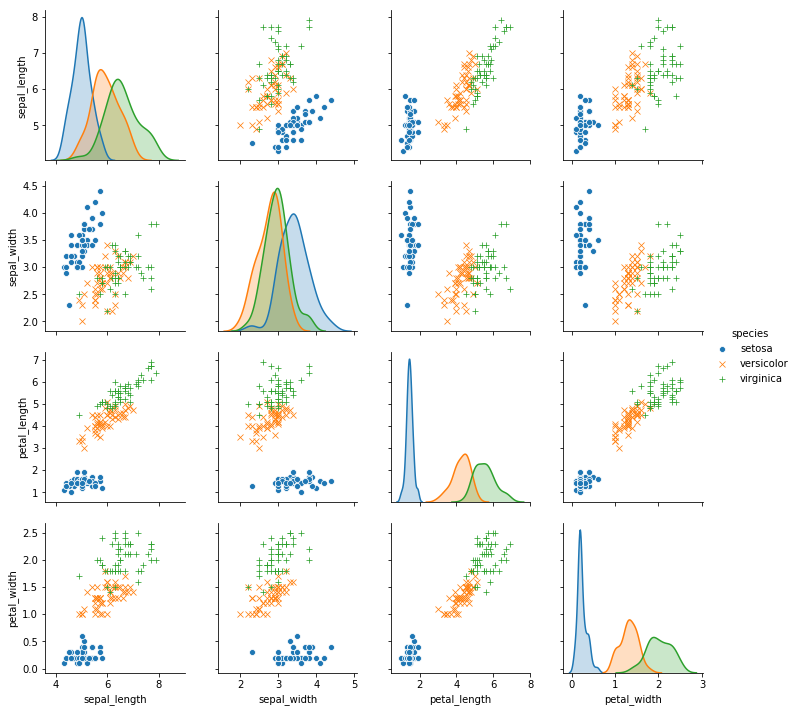

In [26]:
#showoff some of what seaborn can do
sns.pairplot(df, hue="species", diag_kind="kde",markers=['o','x','+'])

In [27]:
#let's group setosa and verginica together for the sake of this machine learning exercise
df['y']= np.where(df['species']=='versicolor', 1,0)
print df.groupby(['y']).size()

y
0    100
1     50
dtype: int64


In [28]:
#split into train and test
X=df.drop('species',1).drop('y',1)
y=df['y']
RANDOM_STATE=0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
print ('the number in training set: '+str(len(X_train)))
print ('the number in test set: '+str(len(X_test)))


the number in training set: 112
the number in test set: 38


In [29]:
#Randomized search for model selection
clf = DecisionTreeClassifier()
# Utility function to report best scores
def report(results, n_top=10):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean OOB score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 4),
              "min_samples_split": sp_randint(2, 5),
              "min_samples_leaf": sp_randint(1, 5),
              "splitter": ["best", "random"],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 30
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

random_search.fit(X_train, y_train)
#this might take a minute to run
print("RandomizedSearchCV examined %d candidate parameter settings." % (n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV examined 30 candidate parameter settings.
Model with rank: 1
Mean OOB score: 0.973 (std: 0.022)
Parameters: {'splitter': 'best', 'min_samples_leaf': 4, 'min_samples_split': 3, 'criterion': 'gini', 'max_features': 3, 'max_depth': 3}

Model with rank: 2
Mean OOB score: 0.964 (std: 0.013)
Parameters: {'splitter': 'best', 'min_samples_leaf': 4, 'min_samples_split': 4, 'criterion': 'entropy', 'max_features': 2, 'max_depth': 3}

Model with rank: 3
Mean OOB score: 0.955 (std: 0.033)
Parameters: {'splitter': 'best', 'min_samples_leaf': 3, 'min_samples_split': 3, 'criterion': 'entropy', 'max_features': 2, 'max_depth': None}

Model with rank: 4
Mean OOB score: 0.946 (std: 0.043)
Parameters: {'splitter': 'best', 'min_samples_leaf': 2, 'min_samples_split': 2, 'criterion': 'gini', 'max_features': 2, 'max_depth': None}

Model with rank: 4
Mean OOB score: 0.946 (std: 0.043)
Parameters: {'splitter': 'best', 'min_samples_leaf': 3, 'min_samples_split': 4, 'criterion': 'gini', 'max_fea

In [23]:
#2.5 Train the random forest according to the best paramater setting given above. Show model outputs.

#YOUR HOMEWORK IS TO SWITCH RANDOM FOREST CLASSIFIED WITH ANOTHER CLASSIFIER FROM THE SCIKIT LEARN API
#http://scikit-learn.org/stable/
clf = DecisionTreeClassifier(splitter='best',max_features=3, criterion='gini',
                             min_samples_split=3,min_samples_leaf=4,max_depth=3)

clf = clf.fit(X_train, y_train)

importances = clf.feature_importances_
names = X.columns
items=sorted(zip(map(lambda r: round(r, 3), clf.feature_importances_), names), reverse=True)

print ('\nfeature importance ')
for r in items:
    print(str(round(r[0],4))+' '+r[1])
    
y_pred=clf.predict(X_test)
y_scores=clf.predict_proba(X_test)
print ('\nconfusion matrix')
print(pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores[:,1])
print('\nauc score '+str(auc(false_positive_rate, true_positive_rate)))

#show a tradeoff curve for precision vs recall


feature importance 
0.506 petal_width
0.25 petal_length
0.245 sepal_length
0.0 sepal_width

confusion matrix
Predicted   0   1  All
True                  
0          21   1   22
1           0  16   16
All        21  17   38

auc score 0.984375


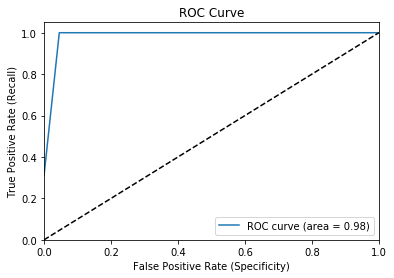

In [24]:
#2.7 ROC Curve
fpr, tpr , threshold = roc_curve(y_test,clf.predict_proba(X_test)[:,1])
roc_auc=auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#Specificity: How many negatives were identified as negative.
plt.xlabel('False Positive Rate (Specificity)')
#Recall: How many positives were identified as positive.
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [1]:
# Upload to S3
#TO GET THIS WORKING, YOU MUST ASSIGN AN ADMIN ROLE TO YOUR EC2 INSTANCE
import boto3
s3 = boto3.resource('s3')
s3.Bucket('s3hw2wherring').put_object(Key='hw2_wherring.ipynb', Body=open('hw2_wherring.ipynb'))